# Jelajahi: Cultural Travel Recommender Application ML Models

Welcome to **JelajahI**, your passport to an immersive cultural journey across Indonesia. Powered by TensorFlow, Keras, and a robust CNN with dense layers, our app revolutionizes cultural travel. Capture the essence of your surroundings through photos, and let JelajahI's advanced image recognition craft personalized recommendations for regional destinations. Dive into detailed cultural insights and curated recommendations for each area, all at your fingertips. Join our community, share your stories, and contribute to a global exchange of knowledge. JelajahI—where every photo opens a portal to Indonesia's cultural wonders, all made possible with cutting-edge technology and the seamless integration of TensorFlow.js (TFJS). Explore, connect, and let JelajahI redefine your cultural travel experience.

## 1. Importing Necessary Libraries for Machine Learning
In this section, essential libraries for machine learning tasks are imported. These include libraries for file operations, numerical operations, plotting, image processing, and model development using TensorFlow and Keras. The code block also checks the TensorFlow version and GPU availability.



In [1]:
# Import necessary libraries for file and path operations
import os
import pathlib

# Import libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd

# Import libraries for plotting
import matplotlib.pyplot as plt

# Import Google Colab specific libraries
from google.colab import auth, files

# Import TensorFlow and related modules
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# Import TensorFlow.js for model conversion
import tensorflowjs as tfjs

# Import Google Sheets and related libraries
import gspread
from google.auth import default

# Display TensorFlow version and GPU availability information
print('\u2022 Using TensorFlow Version:', tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('\u2022 GPU Device Found.')
else:
    print('\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.15.0
• GPU Device Not Found. Running on CPU


## 2. Cloning and Navigating the Dataset Repository
This section involves cloning a GitHub repository containing the batik dataset and navigating to the relevant directory. The **ls** command is used to list the contents of the dataset directory, providing an overview of available files and subdirectories.

In [2]:
# Clone the GitHub repository containing the dataset
!git clone https://github.com/ameliarahmanita/JelajahI-MLTeam.git

Cloning into 'JelajahI-MLTeam'...
remote: Enumerating objects: 3687, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 3687 (delta 5), reused 0 (delta 0), pack-reused 3669
Receiving objects: 100% (3687/3687), 371.94 MiB | 13.71 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (3260/3260), done.


In [3]:
# Navigate to the Dataset directory
%cd JelajahI-MLTeam/Dataset

/content/JelajahI-MLTeam/Dataset


In [4]:
# List the contents of the Dataset directory
!ls

'Batik Lasem'	'Batik Pati'	    'Batik Sekar Jagad'  'Batik Sogan'
'Batik Parang'	'Batik Pekalongan'  'Batik Sidoluhur'	 'Batik Truntum'


## 3. Data Preprocessing and Augmentation for Batik Image Classification
Here, data preprocessing and augmentation techniques are applied to prepare the batik dataset for image classification. ImageDataGenerator is used to perform operations such as rotation, shifting, zooming, and flipping on both the training and validation sets. The generator functions are then configured to load and augment the dataset during model training.

In [5]:
# Specify the directory containing the batik dataset
training_directory = "/content/JelajahI-MLTeam/Dataset"

In [6]:
# Configure data augmentation for training and validation sets
training_datagen = ImageDataGenerator(rescale=1./255.,
                                      rotation_range=20,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='nearest',
                                      validation_split=0.1)

val_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

In [7]:
# Load and prepare the batik dataset for training
train_generator = training_datagen.flow_from_directory(directory=training_directory,
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       target_size=(224, 224),
                                                       subset='training')

val_generator = val_datagen.flow_from_directory(directory=training_directory,
                                               batch_size=32,
                                                class_mode='categorical',
                                                target_size=(224, 224),
                                                subset='validation')

Found 2935 images belonging to 8 classes.
Found 324 images belonging to 8 classes.


## 4. Building Model for Batik Image Classification
This section involves constructing a deep learning model for batik image classification using transfer learning. The MobileNetV2 architecture is used as the base model, and custom layers are added to create the final model. The model is then compiled with specific configurations, including the Adam optimizer, categorical crossentropy loss, and accuracy metric. The learning rate is scheduled, and the model is trained on the prepared dataset.

In [8]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

In [9]:
# Build the model using transfer learning with MobileNetV2 as the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the layers of the base model to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Construct the final model by adding custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Adjust dropout rate if needed
    layers.Dense(8, activation='softmax')
])

# Display the model summary
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                           

In [10]:
# Initialize learning rate and create a LearningRateScheduler
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate / (10 ** (epoch // 10)))

In [11]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Train the model with early stopping, monitoring validation accuracy
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/50
92/92 [==============================] - 157s 2s/step - loss: 0.8177 - accuracy: 0.7380 - val_loss: 0.8297 - val_accuracy: 0.7346
Epoch 2/50
92/92 [==============================] - 137s 1s/step - loss: 0.4763 - accuracy: 0.8416 - val_loss: 0.8524 - val_accuracy: 0.7253
Epoch 3/50
92/92 [==============================] - 138s 1s/step - loss: 0.4009 - accuracy: 0.8702 - val_loss: 0.8858 - val_accuracy: 0.7407
Epoch 4/50
92/92 [==============================] - 148s 2s/step - loss: 0.3037 - accuracy: 0.9019 - val_loss: 0.7570 - val_accuracy: 0.7654
Epoch 5/50
92/92 [==============================] - 150s 2s/step - loss: 0.2845 - accuracy: 0.9124 - val_loss: 0.8530 - val_accuracy: 0.7407
Epoch 6/50
92/92 [==============================] - 133s 1s/step - loss: 0.2670 - accuracy: 0.9158 - val_loss: 0.8152 - val_accuracy: 0.7593
Epoch 7/50
92/92 [==============================] - 140s 2s/step - loss: 0.2432 - accuracy: 0.9254 - val_loss: 0.7021 - val_accuracy: 0.7747
Epoch 8/50
92

## 5. Evaluation: Visualizing Model Training and Validation Performance
In this section, the training history of the model, including accuracy and validation accuracy, is visualized. The training history is stored in a DataFrame, and the last 10 epochs are displayed. A line plot is generated to illustrate the trend of accuracy and validation accuracy over the epochs. The visualization provides insights into the model's learning progress and performance on both the training and validation sets.

In [13]:
# Create a DataFrame to store the training history (loss and metrics)
model_loss = pd.DataFrame(model.history.history)

# Display the last 10 rows of the training history DataFrame
model_loss.tail(10)

,loss,accuracy,val_loss,val_accuracy
40,0.053346,0.983986,0.866517,0.836420
41,0.058682,0.979898,0.855315,0.836420
42,0.051430,0.979557,0.749129,0.851852
43,0.046840,0.987053,1.037004,0.814815
44,0.049239,0.983986,0.914895,0.830247
45,0.048769,0.985009,0.921928,0.842593
46,0.065818,0.976831,0.631823,0.851852
47,0.060336,0.980238,0.960544,0.830247
48,0.065386,0.977172,1.264819,0.799383
49,0.054407,0.980579,0.850507,0.845679


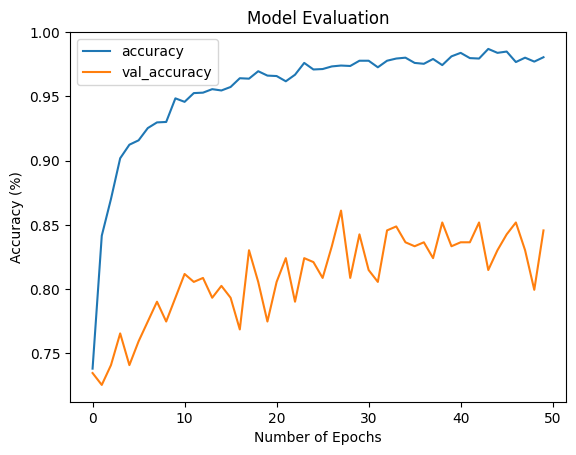

In [14]:
# Extract and plot accuracy and validation accuracy over epochs
mod = model_loss[['accuracy', 'val_accuracy']].plot()

# Customize the plot with title, xlabel, and ylabel
mod.set(
    title="Model Evaluation",
    xlabel="Number of Epochs",
    ylabel="Accuracy (%)"
)

# Show the plot
plt.show()

## 6. Image Classification: Predicting Batik Class from Uploaded Image
This code section enables users to leverage a pre-trained batik image classification model to predict the class of an uploaded image. The step-by-step process involves uploading an image using Google Colab's file upload widget, extracting the file name, loading and preprocessing the image, making predictions using the model, and interpreting the results. The final prediction, indicating the predicted batik class label, is then displayed for user interpretation. The class labels are mapped to specific indices, allowing the model to identify the most likely batik class for the given image. Users can easily replace or expand the class_labels list to accommodate different batik classes.

In [15]:
# Upload the image file using Google Colab's file upload widget
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]

Saving batik pati.jpg to batik pati.jpg


In [16]:
# Load and preprocess the uploaded image for model input
img = image.load_img(file_name, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions using the pre-trained batik image classification model
predictions = model.predict(img_array)

# # Retrieve class indices
# class_indices = train_generator.class_indices

# # Reverse the dictionary to map indices to class labels
# index_to_class = {v: k for k, v in class_indices.items()}

# # Make predictions as before
# predicted_class_index = np.argmax(predictions)

# # Map index to class label
# predicted_class_label = index_to_class[predicted_class_index]

# print(f'The predicted class is: {predicted_class_label}')

# Interpret predictions by identifying the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding class label
class_labels = ['Batik Lasem', 'Batik Parang', 'Batik Pati', 'Batik Pekalongan', 'Batik Sekar Jagad', 'Batik Sidoluhur', 'Batik Sogan', 'Batik Truntum']
predicted_class_label = class_labels[predicted_class_index]

# Display the predicted batik class label
print(f'The predicted class is: {predicted_class_label}')

1/1 [==============================] - 1s 753ms/step
The predicted class is: Batik Pati


In [17]:
# Interpret predictions
predicted_class_indices = np.argsort(predictions[0])[::-1][:3]
predicted_class_labels = [class_labels[i] for i in predicted_class_indices]
predicted_class_probabilities = predictions[0][predicted_class_indices]

# Print the top three predicted classes and their probabilities
for label, probability in zip(predicted_class_labels, predicted_class_probabilities):
    print(f'The predicted class is: {label} with probability: {probability}')

The predicted class is: Batik Pati with probability: 0.9999831914901733
The predicted class is: Batik Pekalongan with probability: 9.094852430280298e-06
The predicted class is: Batik Truntum with probability: 7.520206054323353e-06


## 7. Model Saving and TensorFlow.js Conversion
This code snippet simplifies the process of saving and reusing a batik image classification model. Initially, the trained model is saved in the common .h5 file format for easy storage. Later, the saved model is loaded back into the runtime using the load_model function. To broaden deployment options, the model is then converted to TensorFlow.js format using the save_keras_model function. The success message signals that the conversion is complete, making the model ready for deployment in web browsers or other JavaScript environments. Users can customize filenames based on their preferences.

In [18]:
# Save the trained model in .h5 file format
model.save('/batik_model.h5')

# Download the saved model file
files.download('/batik_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Load the saved image classifier model
model = load_model('/batik_model.h5')

# Convert the loaded model to TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

# Display success message after model conversion
print("Model converted to TensorFlow.js format and saved successfully.")

Model converted to TensorFlow.js format and saved successfully.


In [20]:
# Create a zip file containing the TensorFlow.js model files
!zip -r tfjs_model.zip tfjs_model

# Download the zip file containing the TensorFlow.js model
files.download('tfjs_model.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8. Retrieving Batik Information from Spreadsheet
This code section guides users through the authentication and interaction with a Google Spreadsheet to retrieve detailed information about batik motifs. It includes steps for authenticating the Google account, importing necessary libraries, accessing a specific worksheet, and converting data into a Pandas DataFrame. A function is defined to extract batik origin and description information based on a predicted class label. The code showcases an example usage of the function, demonstrating the retrieval of information for a predicted batik class label. Users can adapt the code for their specific Google Spreadsheet URL, worksheet names, and batik information columns.

In [21]:
# Authenticate the Google account to be linked with Colab
auth.authenticate_user()

In [22]:
# Import necessary libraries for Google Sheets interaction
creds, _ = default()
gc = gspread.authorize(creds)

In [23]:
# Open the Spreadsheet URL and save it into a variable
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/15zScMSf0hkqOMDfAvGq_Klh3nT3qZ80HSZOoCnsXWfc/edit?usp=sharing')

In [24]:
# Access the specific worksheet within the spreadsheet
sheet = spreadsheet.worksheet('Jawa Tengah')

In [25]:
# Retrieve all records from the sheet and convert to a Pandas DataFrame
data = sheet.get_all_records()
batikJaTeng_df = pd.DataFrame(data)

# Display the DataFrame containing batik information
print(batikJaTeng_df)

                Name   Type      Origin  Latitude   Longitude     Province  \
0        Batik Lasem  Batik     Rembang -6.707108  111.331832  Jawa Tengah   
1       Batik Parang  Batik        Solo -7.567375  110.828596  Jawa Tengah   
2         Batik Pati  Batik        Pati -6.753230  111.036045  Jawa Tengah   
3   Batik Pekalongan  Batik  Pekalongan -6.892021  109.682399  Jawa Tengah   
4  Batik Sekar Jagad  Batik        Solo -7.567375  110.828596  Jawa Tengah   
5    Batik Sidoluhur  Batik    Banyumas -7.531320  109.276062  Jawa Tengah   
6        Batik Sogan  Batik        Solo -7.567375  110.828596  Jawa Tengah   
7      Batik Truntum  Batik        Solo -7.567375  110.828596  Jawa Tengah   

                                         Description  
0  Batik Lasem terkenal dengan warna-warna kontra...  
1  Batik Parang dikenal dengan motif geometris ya...  
2  Batik Pati memiliki motif-motif yang bervarias...  
3  Batik Pekalongan memiliki keunikan dalam pengg...  
4  Batik Sekar Jagad m

In [26]:
# Function to get batik informations based on predicted class label
def get_batik_info(predicted_class_label, batikJaTeng_df):
    matching_row = batikJaTeng_df[batikJaTeng_df['Name'] == predicted_class_label]

    if not matching_row.empty:
        info = {
            'Name': matching_row['Name'].values[0],
            'Type': matching_row['Type'].values[0],
            'Origin': matching_row['Origin'].values[0],
            'Latitude': matching_row['Latitude'].values[0],
            'Longitude': matching_row['Longitude'].values[0],
            'Province': matching_row['Province'].values[0],
            'Description': matching_row['Description'].values[0],
        }
        return info
    else:
        return {'error': 'Batik hasn\'t yet been added to JelajahI\'s encyclopedia'}

In [27]:
# Example usage: Retrieve batik information based on the predicted class label
result = get_batik_info(predicted_class_label, batikJaTeng_df)

# Display the result
print(result)

{'Name': 'Batik Pati', 'Type': 'Batik', 'Origin': 'Pati', 'Latitude': -6.753229640231162, 'Longitude': 111.0360452054126, 'Province': 'Jawa Tengah', 'Description': 'Batik Pati memiliki motif-motif yang bervariasi, mencakup pola-pola geometris dan floral. Warna-warna yang digunakan bisa menciptakan tampilan yang elegan dan menarik.'}
